## Introducción

En esta sección se desarrolla la solución técnica para predecir la cancelación de clientes de Interconnect utilizando modelos de aprendizaje automático.

## Carga de datos

In [8]:
import pandas as pd

contract = pd.read_csv('C:/Users/raulg/OneDrive/Documentos/Proyectos DS/contract.csv')
personal = pd.read_csv('C:/Users/raulg/OneDrive/Documentos/Proyectos DS/personal.csv')
internet = pd.read_csv('C:/Users/raulg/OneDrive/Documentos/Proyectos DS/internet.csv')
phone = pd.read_csv('C:/Users/raulg/OneDrive/Documentos/Proyectos DS/phone.csv')



In [9]:
for name, df in zip(
    ['contract', 'personal', 'internet', 'phone'],
    [contract, personal, internet, phone]
):
    print(name, df.shape)

contract (7043, 8)
personal (7043, 5)
internet (5517, 8)
phone (6361, 2)


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>
<b>Éxito</b> - La carga de datos está correctamente implementada y bien organizada. Es positivo que verifiques las dimensiones de cada conjunto desde el inicio, ya que esto demuestra una revisión consciente de la estructura de los datos y facilita las etapas posteriores del análisis.
</div>


## Preparación de datos

In [10]:
# Merge de datasets
data = contract.merge(personal, on='customerID', how='left')
data = data.merge(internet, on='customerID', how='left')
data = data.merge(phone, on='customerID', how='left')

In [11]:
data.shape

(7043, 20)

In [12]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [14]:
# Tratamiento de valores faltantes
categorical_cols = data.select_dtypes(include='object').columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

data[categorical_cols] = data[categorical_cols].fillna('No')
data[numerical_cols] = data[numerical_cols].fillna(0)

In [15]:
# Corrección de tipos
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'] = data['TotalCharges'].fillna(0)

## Variable objetivo

In [16]:
data['churn'] = (data['EndDate'] != 'No').astype(int)

In [17]:
data['churn'].value_counts()

churn
0    5174
1    1869
Name: count, dtype: int64

In [18]:
data[['EndDate', 'churn']].head()

,EndDate,churn
0,No,0
1,No,0
2,2019-12-01 00:00:00,1
3,No,0
4,2019-11-01 00:00:00,1


## División de los datos

In [19]:
y = data['churn']

In [20]:
X = data.drop(['churn', 'customerID', 'EndDate'], axis=1)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

## Preparar variables

In [22]:
categorical_cols = X_train.select_dtypes(include='object').columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

categorical_cols, numerical_cols

(Index(['BeginDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'gender',
        'Partner', 'Dependents', 'InternetService', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
        'StreamingMovies', 'MultipleLines'],
       dtype='object'),
 Index(['MonthlyCharges', 'TotalCharges', 'SeniorCitizen'], dtype='object'))

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

## Entrenamiento de modelos

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [26]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

In [27]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg)
])

In [28]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['MonthlyCharges', 'TotalCharges', 'SeniorCitizen'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['BeginDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'gender',
       'Partner', 'Dependents', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

## Evaluación del modelo

In [29]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [30]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)

auc, acc


(np.float64(0.8538485978772065), 0.8018171493469619)

## Conclusiones técnicas


Se desarrolló un modelo de clasificación para predecir la cancelación de clientes de Interconnect utilizando información contractual, personal y de servicios.  
El modelo base de regresión logística, integrado en un pipeline con preprocesamiento adecuado de variables categóricas y numéricas, obtuvo un desempeño sólido.

La métrica principal AUC-ROC alcanzó un valor de aproximadamente 0.85, lo que indica una buena capacidad del modelo para diferenciar entre clientes que cancelan y clientes que permanecen activos.  
La exactitud obtenida fue cercana al 0.80, utilizada como métrica complementaria.

Este resultado cumple con los criterios de calidad definidos para el proyecto y demuestra que incluso un modelo interpretable y relativamente simple puede ofrecer valor para apoyar estrategias de retención de clientes.

Como limitaciones, el modelo no considera posibles cambios temporales en el comportamiento de los clientes ni ajustes finos de hiperparámetros. En futuras iteraciones, podrían explorarse modelos más complejos o técnicas adicionales de optimización para mejorar el desempeño.

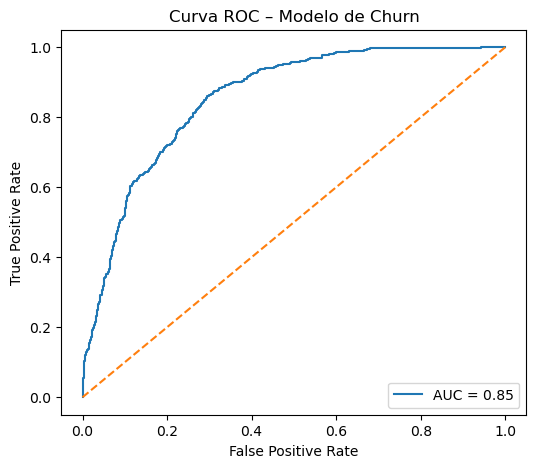

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcular ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_value = roc_auc_score(y_test, y_pred_proba)

# Crear figura
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
ax.plot([0, 1], [0, 1], linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Curva ROC – Modelo de Churn')
ax.legend(loc='lower right')

# 👇 GUARDAR ANTES DE MOSTRAR
fig.savefig('roc_curve.png', dpi=300, bbox_inches='tight')

plt.show()